In [6]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import torch
from networks.mlp_models import MLP3D
from data.neural_field_datasets_shapenet import ModelTransform3D, WeightDataset, FlattenTransform3D


model_config = {
    "out_size": 1,
    "hidden_neurons": [128, 128, 128],
    "use_leaky_relu": False,
    "input_dims": 3,
    "multires": 4,
    "include_input": True,
}


dict_plane = torch.load("./datasets/plane_mlp_weights/occ_1a04e3eab45ca15dd86060f189eb133_jitter_0_model_final.pth", map_location=torch.device('cpu'))

for key in dict_plane.keys():
    print(f"Dim of {key}: {dict_plane[key].size()}")

model_3D = MLP3D(**model_config)
model_3D.load_state_dict(dict_plane)

shapeNetData = WeightDataset("./datasets/plane_mlp_weights", transform=FlattenTransform3D())

Dim of layers.0.weight: torch.Size([128, 27])
Dim of layers.0.bias: torch.Size([128])
Dim of layers.1.weight: torch.Size([128, 128])
Dim of layers.1.bias: torch.Size([128])
Dim of layers.2.weight: torch.Size([128, 128])
Dim of layers.2.bias: torch.Size([128])
Dim of layers.3.weight: torch.Size([1, 128])
Dim of layers.3.bias: torch.Size([1])


In [19]:
shapeNetData[0].shape[0]/17

2161.0

In [3]:
from os import listdir
from os.path import isfile, join

dict_path = "./datasets/plane_mlp_weights"



In [26]:
from collections import OrderedDict
from os import listdir
from os.path import isfile, join

from utils import get_default_device

dict_path = "./datasets/plane_mlp_weights"

files = [f for f in listdir(dict_path) if isfile(join(dict_path, f))]


def get_weight_vector(state_dict: OrderedDict, layer: int, neuron: int) -> torch.Tensor:
    return state_dict[f"layers.{layer}.weight"][:, neuron]

def get_bias(state_dict: OrderedDict, layer: int, neuron: int) -> torch.Tensor:
    return  state_dict[f"layers.{layer}.bias"][neuron]

def get_all_weights(files: list, layer: int, neuron: int) -> torch.Tensor:
    all_weights = torch.Tensor()
    for file in files:
        state_dict = torch.load(dict_path + "/" + file, map_location=torch.device(get_default_device()))
        if all_weights.nelement() > 0:
            all_weights = torch.cat((all_weights, get_weight_vector(state_dict, layer, neuron).unsqueeze(0)))
        else:
            all_weights = get_weight_vector(state_dict, layer, neuron).unsqueeze(0)
    return all_weights



def get_all_biases(files: list, layer: int, neuron: int) -> torch.Tensor:
    all_biases = torch.Tensor()
    for file in files:
        state_dict = torch.load(dict_path + "/" + file)
        all_biases = torch.stack(all_biases, get_bias(state_dict, layer, neuron))

all_weights = torch.zeros(27, 4045, 128)

for i in range(27):
    all_weights[i] = get_all_weights(files, 0, i)

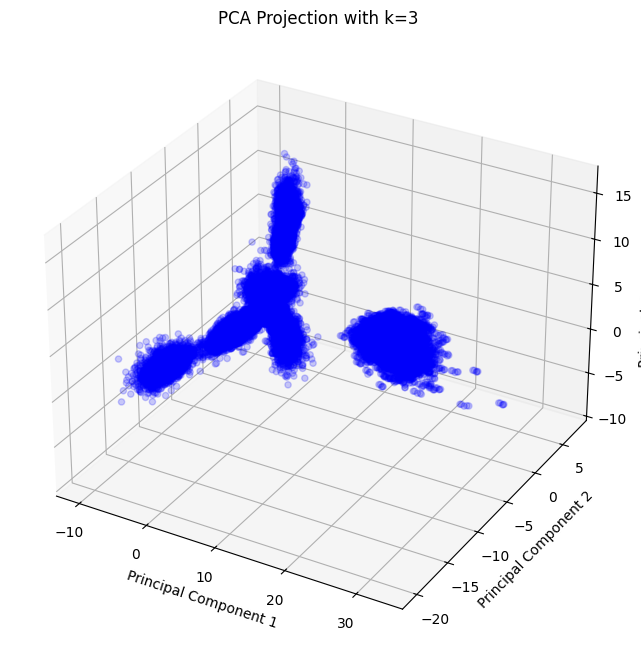

In [28]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reshape the data
data = all_weights.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], c='blue', alpha=0.2)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.show()


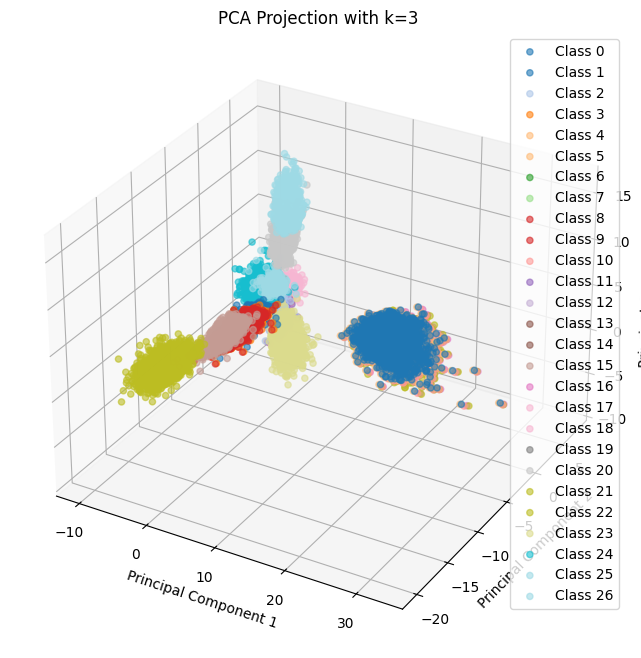

In [29]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# Plot each class with its respective color
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.legend()
plt.show()



In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights[8] #all_weights.view(-1, 128)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the autoencoder
num_epochs = 100
batch_size = 16
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
# cmap = plt.get_cmap("tab20", 27)
# colors = cmap(labels)

# # Plot each class with its respective color
# for class_idx in range(27):
#     class_data = latent_space[labels == class_idx]
#     ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

class_data = latent_space#[labels == class_idx]
ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])



ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Epoch [1/100], Loss: 0.0103
Epoch [2/100], Loss: 0.0108
Epoch [3/100], Loss: 0.0094
Epoch [4/100], Loss: 0.0099
Epoch [5/100], Loss: 0.0092
Epoch [6/100], Loss: 0.0075
Epoch [7/100], Loss: 0.0080
Epoch [8/100], Loss: 0.0091
Epoch [9/100], Loss: 0.0076
Epoch [10/100], Loss: 0.0092
Epoch [11/100], Loss: 0.0103
Epoch [12/100], Loss: 0.0082
Epoch [13/100], Loss: 0.0083
Epoch [14/100], Loss: 0.0078
Epoch [15/100], Loss: 0.0087
Epoch [16/100], Loss: 0.0078
Epoch [17/100], Loss: 0.0090
Epoch [18/100], Loss: 0.0083
Epoch [19/100], Loss: 0.0090
Epoch [20/100], Loss: 0.0070
Epoch [21/100], Loss: 0.0072
Epoch [22/100], Loss: 0.0097
Epoch [23/100], Loss: 0.0084
Epoch [24/100], Loss: 0.0089
Epoch [25/100], Loss: 0.0102
Epoch [26/100], Loss: 0.0079
Epoch [27/100], Loss: 0.0076
Epoch [28/100], Loss: 0.0080
Epoch [29/100], Loss: 0.0071
Epoch [30/100], Loss: 0.0082
Epoch [31/100], Loss: 0.0087
Epoch [32/100], Loss: 0.0092
Epoch [33/100], Loss: 0.0076
Epoch [34/100], Loss: 0.0078
Epoch [35/100], Loss: 0

KeyboardInterrupt: 

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights.view(-1, 128)

# Convert data to numpy array for t-SNE
data_np = data.numpy()

# Perform 3D t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
data_tsne = tsne.fit_transform(data_np)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# Plot each class with its respective color
for class_idx in range(27):
    class_data = data_tsne[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.title('3D t-SNE Projection')
plt.legend()
plt.show()


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 